In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

DATA_PATH = Path().cwd().parent / "data"


def read_data(file_name):
    return pd.read_csv(DATA_PATH / file_name, parse_dates=True)


shipments_df = read_data("shipments.csv")
po_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
skus_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")
_datetime_map = {
    "shipments": (shipments_df, ["ship_date", "eta_date", "actual_delivery_date"]),
    "purchase_orders": (po_df, ["order_date", "promised_date"]),
    "transit_events": (transit_events_df, ["event_ts"]),
}
for _, (df, cols) in _datetime_map.items():
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

rma_df

,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True
...,...,...,...,...,...,...
39995,RMA-0039996,SKU-03476,ST-00497,FIRMWARE,2025-04-21,False
39996,RMA-0039997,SKU-03575,ST-00730,RF_FAULT,2025-06-05,False
39997,RMA-0039998,SKU-03710,ST-01314,DOA,2025-09-01,True
39998,RMA-0039999,SKU-01080,ST-00275,INTERMITTENT,2025-04-06,True


Detect sites with abnormal failure rates (RMA spike detection).

In [2]:
rma_df['rma_date'] = pd.to_datetime(rma_df['rma_date'])

# 2. Aggregate: Create Weekly Time Series
# ---------------------------------------
# Group by Site and Week (W-MON = Weekly starting Monday)
weekly_ts = (
    rma_df
    .groupby(['site_id', pd.Grouper(key='rma_date', freq='W-MON')])
    .size()
    .reset_index(name='rma_count')
    .sort_values(['site_id', 'rma_date'])
)
weekly_ts

,site_id,rma_date,rma_count
0,ST-00001,2023-01-09,1
1,ST-00001,2023-02-20,1
2,ST-00001,2023-04-03,1
3,ST-00001,2023-04-24,1
4,ST-00001,2023-05-01,1
...,...,...,...
37365,ST-02000,2023-11-20,1
37366,ST-02000,2024-06-10,1
37367,ST-02000,2024-06-24,1
37368,ST-02000,2024-07-01,1


In [3]:
grouped_rolling = weekly_ts.groupby('site_id')['rma_count'].rolling(window=8, min_periods=1)

# Calculate Mean and Std, shift by 1 to use *historical* data for the baseline
weekly_ts['rolling_mean'] = weekly_ts.groupby('site_id')['rma_count'].shift(1).rolling(8, min_periods=1).mean().reset_index(0, drop=True)
weekly_ts['rolling_std'] = weekly_ts.groupby('site_id')['rma_count'].shift(1).rolling(8, min_periods=1).std().reset_index(0, drop=True)

# Handle division by zero or NaN std (replace 0 with a small epsilon or 1)
weekly_ts['rolling_std'] = weekly_ts['rolling_std'].fillna(1).replace(0, 1)
weekly_ts['rolling_mean'] = weekly_ts['rolling_mean'].fillna(0)

weekly_ts

,site_id,rma_date,rma_count,rolling_mean,rolling_std
0,ST-00001,2023-01-09,1,0.000,1.000000
1,ST-00001,2023-02-20,1,1.000,1.000000
2,ST-00001,2023-04-03,1,1.000,1.000000
3,ST-00001,2023-04-24,1,1.000,1.000000
4,ST-00001,2023-05-01,1,1.000,1.000000
...,...,...,...,...,...
37365,ST-02000,2023-11-20,1,1.125,0.353553
37366,ST-02000,2024-06-10,1,1.125,0.353553
37367,ST-02000,2024-06-24,1,1.000,1.000000
37368,ST-02000,2024-07-01,1,1.000,1.000000


In [4]:
weekly_ts['z_score'] = (weekly_ts['rma_count'] - weekly_ts['rolling_mean']) / weekly_ts['rolling_std']


In [5]:
anomalies = weekly_ts[
    (weekly_ts['z_score'] > 1.5) & 
    (weekly_ts['rma_count'] >= 2)
].copy()
anomalies = anomalies.merge(sites_df[['site_id', 'region', 'site_type', 'country']], on='site_id', how='left')
anomalies

,site_id,rma_date,rma_count,rolling_mean,rolling_std,z_score,region,site_type,country
0,ST-00001,2025-03-17,2,1.125000,0.353553,2.474874,EMEA,Cell Site,Italy
1,ST-00001,2025-09-22,2,1.125000,0.353553,2.474874,EMEA,Cell Site,Italy
2,ST-00002,2024-01-15,2,1.125000,0.353553,2.474874,APAC,Cell Site,South Korea
3,ST-00002,2024-01-22,2,1.250000,0.462910,1.620185,APAC,Cell Site,South Korea
4,ST-00002,2025-08-18,2,1.250000,0.462910,1.620185,APAC,Cell Site,South Korea
...,...,...,...,...,...,...,...,...,...
947,ST-01996,2024-04-22,2,1.142857,0.377964,2.267787,EMEA,Cell Site,Germany
948,ST-01998,2023-12-11,2,1.142857,0.377964,2.267787,APAC,Cell Site,Indonesia
949,ST-01999,2024-04-08,2,1.125000,0.353553,2.474874,AMER,Warehouse,Chile
950,ST-01999,2024-12-02,2,1.250000,0.462910,1.620185,AMER,Warehouse,Chile


In [6]:
anomalies = anomalies.sort_values('z_score', ascending=False)

print(f"Detected {len(anomalies)} anomalous spikes.")
anomalies

Detected 952 anomalous spikes.


,site_id,rma_date,rma_count,rolling_mean,rolling_std,z_score,region,site_type,country
665,ST-01400,2025-06-16,4,1.125,0.353553,8.131728,AMER,Cell Site,Argentina
838,ST-01729,2025-05-05,4,1.250,0.462910,5.940679,EMEA,Cell Site,Germany
420,ST-00858,2025-01-27,3,1.125,0.353553,5.303301,EMEA,Cell Site,Italy
922,ST-01940,2025-01-20,3,1.125,0.353553,5.303301,APAC,Cell Site,Indonesia
392,ST-00806,2024-04-08,3,1.125,0.353553,5.303301,APAC,Warehouse,India
...,...,...,...,...,...,...,...,...,...
26,ST-00071,2025-06-23,2,1.250,0.462910,1.620185,AMER,Cell Site,Mexico
3,ST-00002,2024-01-22,2,1.250,0.462910,1.620185,APAC,Cell Site,South Korea
4,ST-00002,2025-08-18,2,1.250,0.462910,1.620185,APAC,Cell Site,South Korea
18,ST-00061,2024-12-16,2,1.250,0.462910,1.620185,EMEA,Cell Site,Italy


In [7]:
# per site failures 

# add encoded failure reasons count to sites table
failures_count_by_site = (
    rma_df
    .groupby('site_id')['reason_code']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
failures_count_by_site

sites_enriched = sites_df.merge(failures_count_by_site, on='site_id', how='left').fillna(0)
# if operator = 0 - null
sites_enriched['operator'] = sites_enriched['operator'].replace(0, np.nan)
sites_enriched


,site_id,region,country,site_type,operator,latitude,longitude,DOA,FIRMWARE,INTERMITTENT,MECH_DAMAGE,NO_POWER,OTHER,OVERHEAT,RF_FAULT
0,ST-00001,EMEA,Italy,Cell Site,Three,44.65748,-3.44596,3,3,3,2,1,6,3,7
1,ST-00002,APAC,South Korea,Cell Site,Singtel,19.46501,122.29595,5,5,3,2,3,2,3,0
2,ST-00003,EMEA,Austria,Warehouse,NaN,41.41491,27.75070,4,7,1,1,1,1,5,7
3,ST-00004,EMEA,Italy,Integration Center,NaN,51.17115,-1.20329,0,6,4,2,1,1,2,2
4,ST-00005,AMER,Canada,Cell Site,Verizon,-19.96994,-93.20117,2,3,0,4,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ST-01996,EMEA,Germany,Cell Site,Deutsche Telekom,51.78151,16.61375,6,2,2,2,2,1,1,6
1996,ST-01997,EMEA,UK,Integration Center,NaN,42.72560,-2.44060,5,3,2,2,0,4,3,3
1997,ST-01998,APAC,Indonesia,Cell Site,Bharti Airtel,6.12165,95.68893,3,0,1,3,3,2,4,1
1998,ST-01999,AMER,Chile,Warehouse,NaN,38.59298,-88.55401,3,5,1,2,3,5,1,4


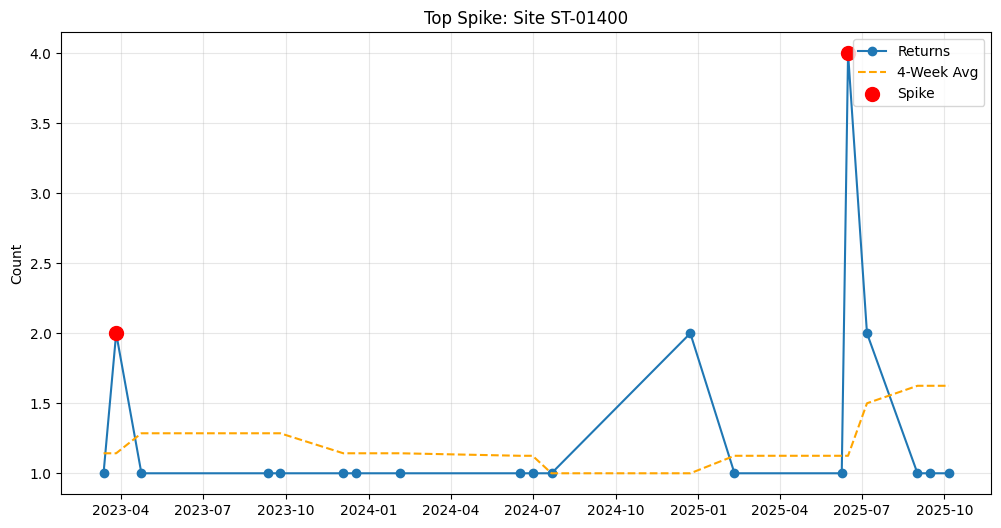

In [8]:
top_site = anomalies.iloc[0]['site_id']
site_data = weekly_ts[weekly_ts['site_id'] == top_site]

plt.figure(figsize=(12, 6))
plt.plot(site_data['rma_date'], site_data['rma_count'], marker='o', label='Returns')
plt.plot(site_data['rma_date'], site_data['rolling_mean'], linestyle='--', color='orange', label='4-Week Avg')

# Highlight anomalies
site_anoms = anomalies[anomalies['site_id'] == top_site]
plt.scatter(site_anoms['rma_date'], site_anoms['rma_count'], color='red', s=100, zorder=5, label='Spike')

plt.title(f"Top Spike: Site {top_site}")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
anomalies

,site_id,rma_date,rma_count,rolling_mean,rolling_std,z_score,region,site_type,country
665,ST-01400,2025-06-16,4,1.125,0.353553,8.131728,AMER,Cell Site,Argentina
838,ST-01729,2025-05-05,4,1.250,0.462910,5.940679,EMEA,Cell Site,Germany
420,ST-00858,2025-01-27,3,1.125,0.353553,5.303301,EMEA,Cell Site,Italy
922,ST-01940,2025-01-20,3,1.125,0.353553,5.303301,APAC,Cell Site,Indonesia
392,ST-00806,2024-04-08,3,1.125,0.353553,5.303301,APAC,Warehouse,India
...,...,...,...,...,...,...,...,...,...
26,ST-00071,2025-06-23,2,1.250,0.462910,1.620185,AMER,Cell Site,Mexico
3,ST-00002,2024-01-22,2,1.250,0.462910,1.620185,APAC,Cell Site,South Korea
4,ST-00002,2025-08-18,2,1.250,0.462910,1.620185,APAC,Cell Site,South Korea
18,ST-00061,2024-12-16,2,1.250,0.462910,1.620185,EMEA,Cell Site,Italy


### Vendor Analysis

In [10]:
# Enrich RMA data with SKU and Site metadata for correlation analysis
rich_rma_df = (
    rma_df
    .merge(skus_df[['sku_id', 'vendor', 'category', 'technology']], on='sku_id', how='left')
    .merge(sites_df[['site_id', 'region', 'site_type']], on='site_id', how='left')
)

print(f"Enriched shape: {rich_rma_df.shape}")
rich_rma_df.head()

Enriched shape: (40000, 11)


,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty,vendor,category,technology,region,site_type
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True,ZTE,Power,Dual (4G/5G),APAC,Integration Center
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False,Nokia,RAN,4G,EMEA,Cell Site
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True,Juniper,Antenna,Dual (4G/5G),EMEA,Warehouse
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True,Samsung,Edge Router,4G,EMEA,Cell Site
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True,HPE Aruba,RAN,4G,EMEA,Warehouse


In [11]:
# print correlation between failure probability and rest

corr = rich_rma_df.groupby('vendor')['reason_code'].value_counts(normalize=True).unstack().fillna(0)
print(corr)

reason_code       DOA  FIRMWARE  INTERMITTENT  MECH_DAMAGE  NO_POWER  \
vendor                                                                 
Ciena        0.131747  0.148184      0.101570     0.099853  0.094455   
Cisco        0.119555  0.151500      0.095353     0.109148  0.099226   
Ericsson     0.121234  0.154896      0.101460     0.096281  0.103814   
HPE Aruba    0.127444  0.150546      0.103326     0.097994  0.102564   
Huawei       0.127023  0.148847      0.101275     0.102011  0.091712   
Juniper      0.111054  0.152280      0.102809     0.096625  0.098944   
NEC          0.128828  0.145280      0.101746     0.102759  0.106808   
Nokia        0.119540  0.147528      0.094690     0.102799  0.105676   
Samsung      0.121399  0.156365      0.103669     0.100714  0.094804   
ZTE          0.123065  0.146681      0.103647     0.096563  0.100761   

reason_code     OTHER  OVERHEAT  RF_FAULT  
vendor                                     
Ciena        0.150393  0.073847  0.199951  
Cis

### SKU analysis

In [12]:
# count all shipements.ship_qty for each sku_id

total_shipments = po_df.groupby('sku_id')['order_qty'].sum().reset_index(name='total_shipped_qty')
total_shipments

,sku_id,total_shipped_qty
0,SKU-00001,309
1,SKU-00002,278
2,SKU-00003,252
3,SKU-00004,324
4,SKU-00005,264
...,...,...
4995,SKU-04996,277
4996,SKU-04997,222
4997,SKU-04998,183
4998,SKU-04999,353


In [13]:
# most suspicious SKUs by failure rate
sku_size = inventory_df.groupby('sku_id')['on_hand_qty'].mean().reset_index(name='avg_inventory')
total_sku_rmas = rma_df.groupby('sku_id').size().reset_index(name='total_returns')
total_shipments = po_df.groupby('sku_id')['order_qty'].sum().reset_index(name='total_shipped_qty')

sku_health = pd.merge(total_sku_rmas, sku_size, on='sku_id', how='inner')
sku_health = pd.merge(sku_health, total_shipments, on='sku_id', how='inner')
sku_health['failure_rate'] = sku_health['total_returns'] / sku_health['total_shipped_qty']
# merge technology from skus_df
sku_health = pd.merge(sku_health, skus_df, on='sku_id', how='left')
sku_health = sku_health.sort_values('failure_rate', ascending=False)


failure_reason_count_by_sku = (
    rma_df
    .groupby('sku_id')['reason_code']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
sku_health = sku_health.merge(failure_reason_count_by_sku, on='sku_id', how='left').fillna(0)


sku_health # THIS TABLE WILL BE USEFULL FOR SKU ANALYSIS


,sku_id,total_returns,avg_inventory,total_shipped_qty,failure_rate,vendor,category,technology,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days,DOA,FIRMWARE,INTERMITTENT,MECH_DAMAGE,NO_POWER,OTHER,OVERHEAT,RF_FAULT
0,SKU-02358,16,9.030303,146,0.109589,Cisco,Edge Router,4G,30.97,0.3274,223.19,44,3,0,2,3,3,1,0,4
1,SKU-03084,19,9.071429,184,0.103261,Samsung,Optical Transport,5G,4.28,0.0568,334.83,9,2,4,3,1,1,4,1,3
2,SKU-01171,17,9.692308,168,0.101190,Ciena,Small Cell,5G,35.58,0.3592,564.91,65,2,1,2,2,1,4,2,3
3,SKU-04067,14,8.418605,140,0.100000,Samsung,Small Cell,Dual (4G/5G),21.32,0.2151,537.65,26,2,0,1,4,0,3,0,4
4,SKU-03133,12,9.476190,132,0.090909,Cisco,Fiber,5G,2.46,0.0317,219.01,32,2,2,0,0,2,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,SKU-00789,1,9.176471,283,0.003534,Juniper,Edge Router,5G,30.24,0.3175,719.02,7,0,0,0,1,0,0,0,0
4994,SKU-03586,1,9.233333,309,0.003236,ZTE,Cabling,Dual (4G/5G),5.71,0.0768,370.97,48,0,0,0,0,0,0,0,1
4995,SKU-04825,1,8.048780,314,0.003185,Nokia,Optical Transport,5G,19.98,0.2166,282.76,33,0,0,0,1,0,0,0,0
4996,SKU-02596,1,8.150000,315,0.003175,Cisco,Power,5G,15.54,0.1593,314.53,58,0,0,0,1,0,0,0,0


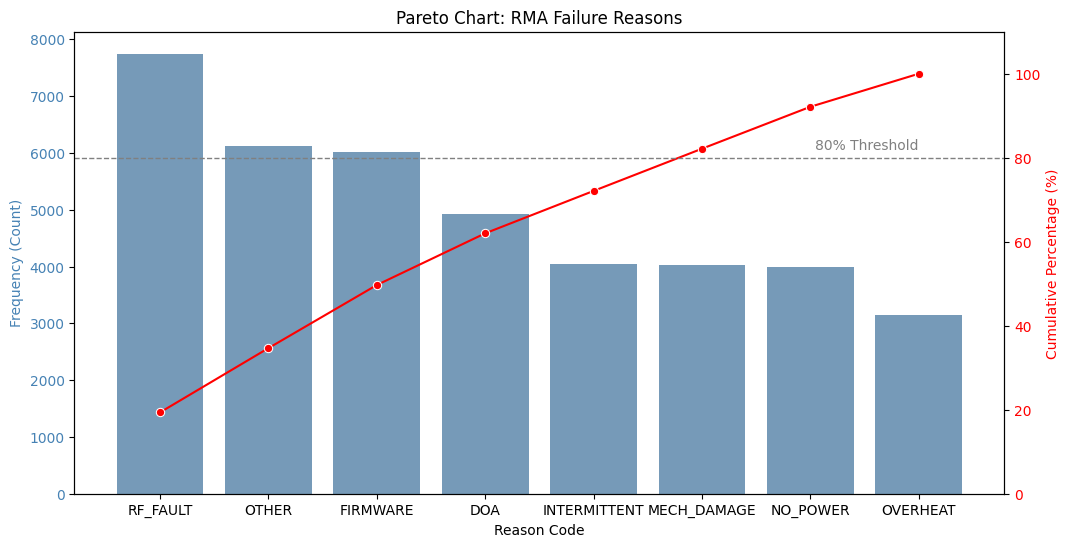

In [14]:
# 1. Calculate Counts and Cumulative Percentage
pareto_df = rma_df['reason_code'].value_counts().reset_index()
pareto_df.columns = ['reason_code', 'count']
pareto_df['cumulative_percentage'] = pareto_df['count'].cumsum() / pareto_df['count'].sum() * 100

# 2. Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Plot (Counts)
sns.barplot(data=pareto_df, x='reason_code', y='count', color='steelblue', ax=ax1, alpha=0.8)
ax1.set_ylabel('Frequency (Count)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xlabel('Reason Code')

# Line Plot (Cumulative %)
ax2 = ax1.twinx()
sns.lineplot(data=pareto_df, x='reason_code', y='cumulative_percentage', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 110)

# Add 80% cutoff line
ax2.axhline(80, color='grey', linestyle='--', linewidth=1)
ax2.text(len(pareto_df)-1, 82, '80% Threshold', color='grey', ha='right')

plt.title('Pareto Chart: RMA Failure Reasons')
plt.show()

C:\Users\miskibin\AppData\Local\Temp\ipykernel_19304\2735554266.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_stats, x='region', y='return_rate_pct', palette='viridis')


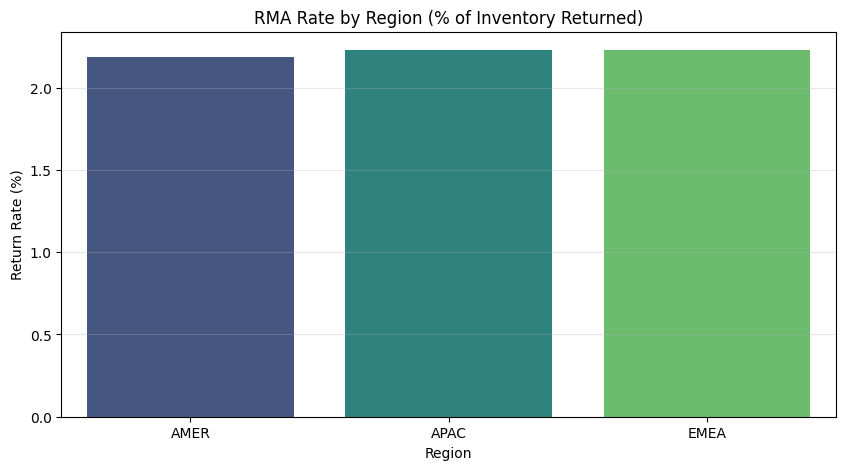

In [15]:
# 1. Get Inventory by Region (joining Inventory -> Sites)
inv_w_region = inventory_df.merge(sites_df[['site_id', 'region']], on='site_id', how='left')
region_inv = inv_w_region.groupby('region')['on_hand_qty'].sum().reset_index(name='total_inventory')

# 2. Get Returns by Region (using rich_rma_df created earlier)
region_rma = rich_rma_df.groupby('region').size().reset_index(name='total_returns')

# 3. Merge and Calculate Rate
region_stats = pd.merge(region_inv, region_rma, on='region')
region_stats['return_rate_pct'] = (region_stats['total_returns'] / region_stats['total_inventory']) * 100

# 4. Visualize
plt.figure(figsize=(10, 5))
sns.barplot(data=region_stats, x='region', y='return_rate_pct', palette='viridis')
plt.title('RMA Rate by Region (% of Inventory Returned)')
plt.ylabel('Return Rate (%)')
plt.xlabel('Region')
plt.grid(axis='y', alpha=0.3)
plt.show()

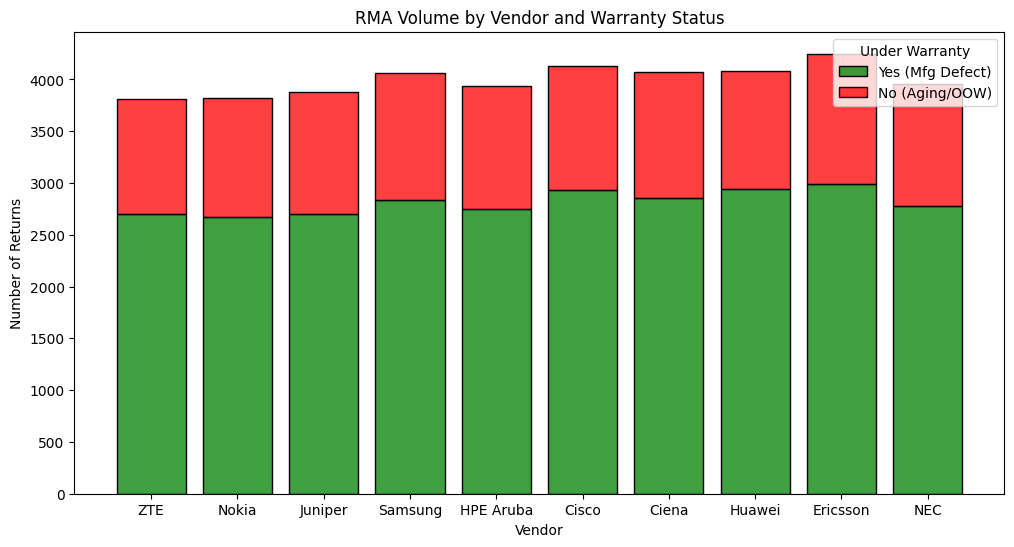

In [16]:
# 1. Aggregate data
vendor_warranty = rich_rma_df.groupby(['vendor', 'under_warranty']).size().reset_index(name='count')

# 2. Plot Stacked Bar Chart
plt.figure(figsize=(12, 6))
sns.histplot(
    data=rich_rma_df, 
    x='vendor', 
    hue='under_warranty', 
    multiple='stack', 
    shrink=0.8, 
    palette={True: 'green', False: 'red'}
)
plt.title('RMA Volume by Vendor and Warranty Status')
plt.xlabel('Vendor')
plt.ylabel('Number of Returns')
plt.legend(title='Under Warranty', labels=['Yes (Mfg Defect)', 'No (Aging/OOW)'])
plt.show()

In [17]:
# 1. Get failure counts by Technology
tech_failures = rich_rma_df['technology'].value_counts().reset_index()
# add what percentage of total items in given technology are failing
sku_health_tech = sku_health.groupby('technology').agg({'total_returns': 'sum', 'total_shipped_qty': 'sum'}).reset_index()
sku_health_tech['failure_rate_pct'] = (sku_health_tech['total_returns'] / sku_health_tech['total_shipped_qty']) * 100


sku_health_tech


,technology,total_returns,total_shipped_qty,failure_rate_pct
0,4G,13972,469335,2.976978
1,5G,18175,612420,2.967735
2,Dual (4G/5G),7853,267339,2.937469


In [18]:
# create rma_enriched (merge with skus and sites    )
# 
rma_enriched = (
    rma_df
    .merge(skus_df, on='sku_id', how='left')
    .merge(sites_df, on='site_id', how='left')
)
rma_enriched

,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty,vendor,category,technology,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days,region,country,site_type,operator,latitude,longitude
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True,ZTE,Power,Dual (4G/5G),12.01,0.1249,923.45,58,APAC,Indonesia,Integration Center,NaN,18.57219,92.19677
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False,Nokia,RAN,4G,28.21,0.2884,785.96,83,EMEA,Sweden,Cell Site,A1 Telekom,44.68328,16.71099
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True,Juniper,Antenna,Dual (4G/5G),10.51,0.1129,1762.87,26,EMEA,Sweden,Warehouse,NaN,37.37533,4.08934
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True,Samsung,Edge Router,4G,19.21,0.2071,953.13,71,EMEA,Italy,Cell Site,Three,55.56093,18.76542
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True,HPE Aruba,RAN,4G,7.03,0.0731,713.08,24,EMEA,Germany,Warehouse,NaN,41.91526,12.05442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,RMA-0039996,SKU-03476,ST-00497,FIRMWARE,2025-04-21,False,NEC,RAN,Dual (4G/5G),39.44,0.4028,264.40,53,APAC,Malaysia,Cell Site,Reliance Jio,35.74836,98.48337
39996,RMA-0039997,SKU-03575,ST-00730,RF_FAULT,2025-06-05,False,HPE Aruba,Cabling,5G,8.58,0.0865,980.73,65,EMEA,Sweden,Cell Site,Vodafone,54.34287,27.81219
39997,RMA-0039998,SKU-03710,ST-01314,DOA,2025-09-01,True,Ciena,RAN,5G,20.76,0.2239,471.04,35,EMEA,Italy,Warehouse,NaN,59.59711,22.92573
39998,RMA-0039999,SKU-01080,ST-00275,INTERMITTENT,2025-04-06,True,Juniper,Optical Transport,5G,12.89,0.1405,823.13,70,EMEA,Germany,Cell Site,Deutsche Telekom,51.32212,28.81153


In [20]:
# sku_health, rma_enriched, sites_enriched

# save to csv
sku_health.to_csv(DATA_PATH / 'rma' / "sku_health.csv", index=False)
rma_enriched.to_csv(DATA_PATH / 'rma' / "rma_enriched.csv", index=False)
sites_enriched.to_csv(DATA_PATH / 'rma' / "sites_enriched.csv", index=False)
anomalies.to_csv(DATA_PATH / 'rma' / "anomalies.csv", index=False)